In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('train.csv')
df.shape

(1460, 81)

- The dataset has 81 variables in total which is a large number to browse through. 
- So it seems reasonable to first rely on the Data Wrangler to take the first impression of the dataset content, datatypes, distributions and missing and distinct values.

In [3]:
# Creating a series with the percentage of NaN values in columns
nan_percent = df.isnull().mean()*100

In [4]:
# Creating a list of column names with 30+ percent NaNs (feels justified to drop them, though it's open to debate)
cols_30plus_nans = nan_percent[nan_percent > 30].index.tolist()
print(cols_30plus_nans)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [5]:
# Dropping high NaN columns
df_v2 = df.drop(cols_30plus_nans, axis=1)
# Dropping the 'Id' column as being uninformative
df_v2.drop('Id', axis=1, inplace=True)
# Dropping duplicates in case there are any
df_v2.drop_duplicates(inplace=True)
df_v2.shape

(1460, 74)

In [6]:
# Checking the remaining columns with NaNs
nan_percent[(nan_percent <= 30) & (nan_percent > 0)]

LotFrontage     17.739726
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
dtype: float64

In [7]:
# Creating a list of column names with smaller percentage of NaNs
cols_30minus_nans = nan_percent[(nan_percent <= 30) & (nan_percent > 0)].index.tolist()
print(cols_30minus_nans)

['LotFrontage', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


- It seems reasonable to do a small research whether these columns can be potential predictors for SalePrice. If not, we can just dispose of them to avoid the hassle of dealing with NaN values. 
- But first let's one-hot-encode the 'object' features to test if they correlate with the target.

In [8]:
cols_nan_target = cols_30minus_nans + ['SalePrice']
df_v2_nan = df_v2[cols_nan_target]      # Creating a DataFrame with only NaN-containing columns plus the target for further correlating them
df_v2_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   MasVnrArea    1452 non-null   float64
 2   BsmtQual      1423 non-null   object 
 3   BsmtCond      1423 non-null   object 
 4   BsmtExposure  1422 non-null   object 
 5   BsmtFinType1  1423 non-null   object 
 6   BsmtFinType2  1422 non-null   object 
 7   Electrical    1459 non-null   object 
 8   GarageType    1379 non-null   object 
 9   GarageYrBlt   1379 non-null   float64
 10  GarageFinish  1379 non-null   object 
 11  GarageQual    1379 non-null   object 
 12  GarageCond    1379 non-null   object 
 13  SalePrice     1460 non-null   int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 159.8+ KB


In [9]:
df_v2_nan.select_dtypes(exclude='number').nunique()     # checking the number of unique values in 'object' columns

BsmtQual        4
BsmtCond        4
BsmtExposure    4
BsmtFinType1    6
BsmtFinType2    6
Electrical      5
GarageType      6
GarageFinish    3
GarageQual      5
GarageCond      5
dtype: int64

In [10]:
# One-hot-encoding the non-numeric features
df_v2_nan_dummies = pd.get_dummies(df_v2_nan, columns = df_v2_nan.select_dtypes(exclude='number').columns.tolist())
df_v2_nan_dummies.columns

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice', 'BsmtQual_Ex',
       'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Fa',
       'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av',
       'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
       'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ',
       'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf',
       'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ',
       'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf',
       'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP',
       'Electrical_Mix', 'Electrical_SBrkr', 'GarageType_2Types',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_Fin',
       'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Ex',
       'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA',
       'GarageCond_Ex', 'GarageCond_F

In [11]:
# Filtering out strong enough (|r| > 0.45) correlations between features and target
corrs = df_v2_nan_dummies.corr()['SalePrice'].drop('SalePrice')
high_corr = corrs[abs(corrs) > 0.45]
high_corr

MasVnrArea     0.477493
GarageYrBlt    0.486362
BsmtQual_Ex    0.553105
BsmtQual_TA   -0.452394
Name: SalePrice, dtype: float64

- Only two boolean subfeatures of the original categorical feature 'BsmtQual' (basement quality) showed relatively high correlations with 'SalePrice'. Let's check how frequent they are among others.

In [12]:
df_v2_nan['BsmtQual'].value_counts()

BsmtQual
TA    649
Gd    618
Ex    121
Fa     35
Name: count, dtype: int64

- Seems reasonable to keep "TA" and "Ex" subfeatures for further analysis. No need to impute NaN values thanks to the nature of pd.get_dummies() transformation.
- We will also keep numerical features "MasVnrArea" (8 NaNs) and GarageYrBlt (81 NaNs). 
- Let's explore them more closely to decide on dropping vs imputing the NaN values.

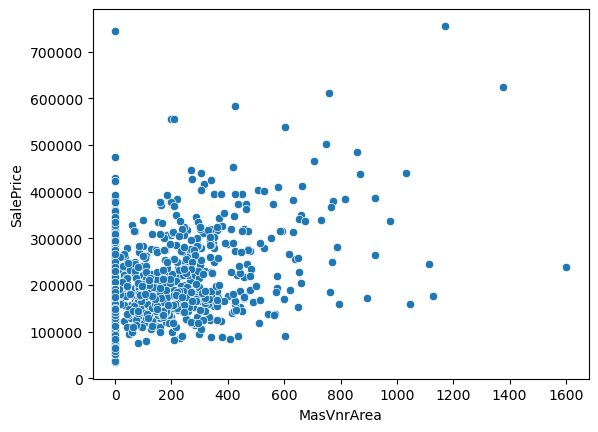

In [13]:
sns.scatterplot(df, x = 'MasVnrArea', y = 'SalePrice') # MasVnrArea stands for masonry veneer area in square feet
plt.show()

In [ ]:
# Calculating the number of zero (not NaN!) values present in the feature
df_v2.MasVnrArea[df.MasVnrArea == 0].shape[0]

861

- The 'MasVnrArea' feature has lots of zero values which is well understandable as not every house has this type of construction material.
- Given the distribution is the opposit of normal we decide on replacing missing values with the median value

In [15]:
df_v2.MasVnrArea = df_v2.MasVnrArea.fillna(df_v2.MasVnrArea.median())
df_v2.MasVnrArea.isnull().sum()

0

- Another potentially interesting feature, 'GarageYrBlt' (year garage was built), has 81 missing values which is a relatively high number.
- On the other hand, the dataset has a closely related feature ('YearBuit' - original construction year) without omitted values.
- Let's check whether these two features are good correlated. If this is the case, we can just exclude 'GarageYrBlt' from further analysis as an obviously less significant house property. Besides, in doing so we get rid of a potential multicollinearity problem.

In [16]:
df_v2.GarageYrBlt.corr(df_v2["YearBuilt"]).round(3)

0.826

- The correlation coefficient is very high. Hence dropping the feature.

## Constructing the final cleaned dataframe

In [17]:
print(cols_30minus_nans)        # recollecting the names of remaining features (wit NaNs) which mostly have a weak correlation with the target

['LotFrontage', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


- 'MasVnrArea' and 'BsmtQual' will be kept, the others will be dropped

In [18]:
cols_to_keep = ['MasVnrArea', 'BsmtQual']
cols_to_drop = [x for x in cols_30minus_nans if x not in cols_to_keep]
df3 = df_v2.drop(cols_30minus_nans, axis=1)

# Checking if any NaNs left
has_nans = False
for column, nan_count in df3.isnull().sum().items():
    if nan_count > 0:
        print(f"Column {column} still has {nan_count} NaN(s)")
        has_nans = True
if not has_nans:
    print("No NaNs detected!")

No NaNs detected!


### Now let's filter out numeric features if they are not or only weakly (|r|<0.45) correlated with the target

In [19]:
corr_matrix = df3.select_dtypes(include='number').corr().round(2)               # calculating all correlations
low_corrs = corr_matrix['SalePrice'][abs(corr_matrix['SalePrice']) <= 0.45]     # extracting low correlations (r<=0.45)
print(low_corrs)

MSSubClass      -0.08
LotArea          0.26
OverallCond     -0.08
BsmtFinSF1       0.39
BsmtFinSF2      -0.01
BsmtUnfSF        0.21
2ndFlrSF         0.32
LowQualFinSF    -0.03
BsmtFullBath     0.23
BsmtHalfBath    -0.02
HalfBath         0.28
BedroomAbvGr     0.17
KitchenAbvGr    -0.14
WoodDeckSF       0.32
OpenPorchSF      0.32
EnclosedPorch   -0.13
3SsnPorch        0.04
ScreenPorch      0.11
PoolArea         0.09
MiscVal         -0.02
MoSold           0.05
YrSold          -0.03
Name: SalePrice, dtype: float64


In [20]:
cols_to_drop = list(low_corrs.index)
df3 = df3.drop(cols_to_drop, axis=1)    # dropping the low correlated numeric features from the dataframe
df3.shape

(1460, 39)

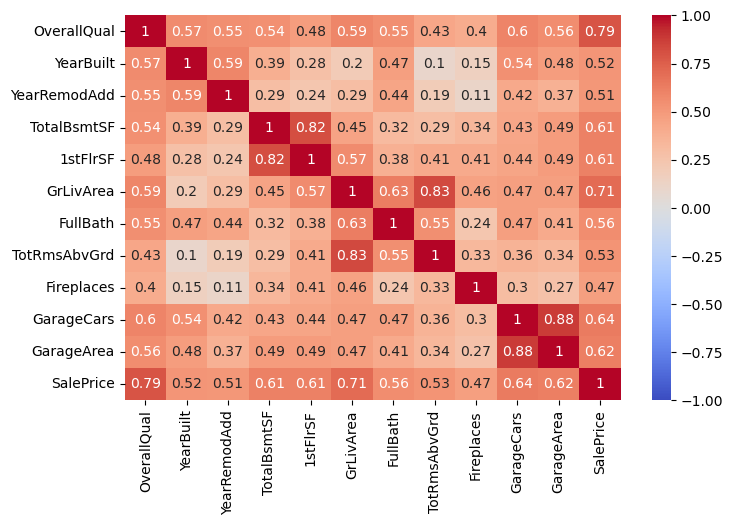

In [23]:
# Exploring the remaining correlations among numerical features

corr_matrix2 = df3.select_dtypes(include='number').corr().round(2)

plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

### Let's filter out redundant features (strongly mutually correlated: |r| > 0.8) to try to avoid multicollinearity problems

- 'TotalBsmtSF' (total basement area square feet) and '1stFlrSF' (first Floor square feet) features are strongly correlated and have a comparable correlation strength to the target.

<Axes: xlabel='1stFlrSF', ylabel='Count'>

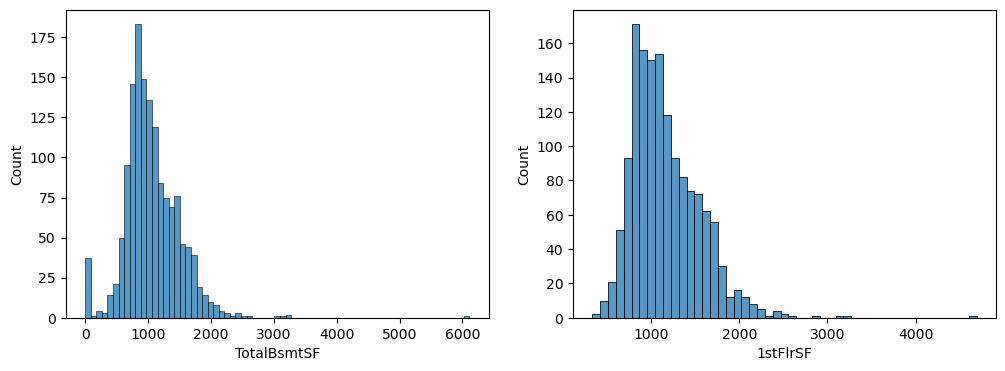

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data = df3, x = 'TotalBsmtSF', ax = ax1)
sns.histplot(data = df3, x = '1stFlrSF', ax = ax2)

- Based on common sense and taking into consideration a slightly better looking distribution of '1stFlrSF' feature, let's keep it and drop the other one.

In [24]:
df3 = df3.drop('TotalBsmtSF', axis=1)

- The second pair of strongly correlated features are 'GrLivArea' (Above ground living area square feet) and 'TotRmsAbvGrd' (total rooms above ground)

<Axes: xlabel='TotRmsAbvGrd', ylabel='Count'>

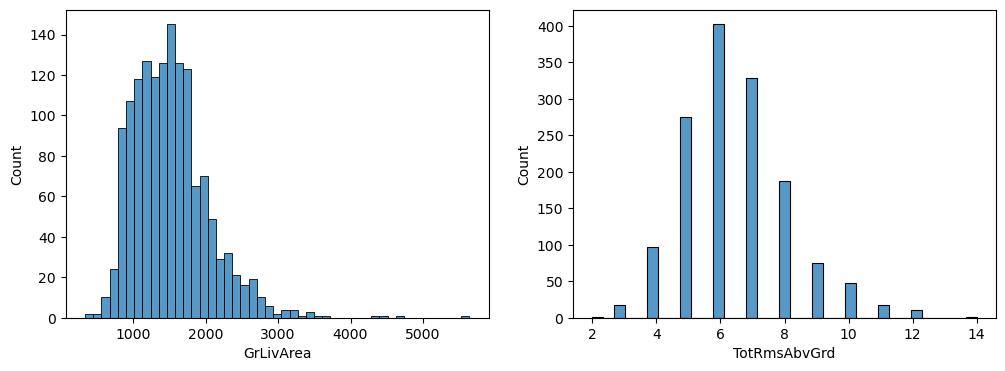

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data = df3, x = 'GrLivArea', ax = ax1)
sns.histplot(data = df3, x = 'TotRmsAbvGrd', ax = ax2)

- Both distributions look relatively good, but 'GrLivArea' is considerably stronger (r=0.71) correlated with the target variable than 'TotRmsAbvGrd' (r=0.53). That's why we drop the latter.

In [26]:
df3 = df3.drop('TotRmsAbvGrd', axis=1)

- The last pair of strongly correlated features are 'GarageCars' (size of garage in car capacity) and 'GarageArea' (size of garage in square feet).

<Axes: xlabel='GarageArea', ylabel='Count'>

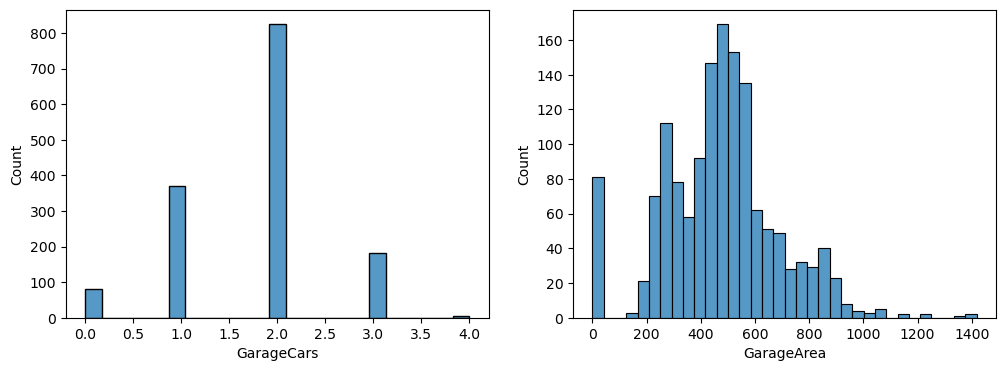

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data = df3, x = 'GarageCars', ax = ax1)
sns.histplot(data = df3, x = 'GarageArea', ax = ax2)

- Both features are comparable in correlation strength with the target variable but it seems more reasonable to keep 'GarageArea' feature due to its much higher granularity.

In [29]:
df3 = df3.drop('GarageCars', axis=1)

### Now let's deal with the categorical features

In [32]:
df3.select_dtypes(exclude='number').nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
ExterQual         4
ExterCond         5
Foundation        6
Heating           6
HeatingQC         5
CentralAir        2
KitchenQual       4
Functional        7
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [36]:
df3.Exterior2nd.value_counts()

Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: count, dtype: int64